## Importing essential libraries

In [2]:
import os
import random
import json
import pandas as pd
import numpy as np
import matplotlib as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Hardcoding seed for determinism

In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data imports

In [6]:
IMAGES_DIR = os.path.join('.', 'A2_Images')
TRAIN_JSONL = os.path.join('.', 'A2_train_v3.jsonl')

In [7]:
# 1) Read JSONL into a pandas DataFrame
# - Each line in A2_train_v3.jsonl is a JSON object with Image_ID, Hypothesis, Label, and (optionally) Premise
# - We parse it line-by-line to build a DataFrame.

records = []
with open(TRAIN_JSONL, 'r') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        j = json.loads(line)
        records.append(j)

df = pd.DataFrame(records)
print(f"Loaded {len(df)} rows")
df.head()

Loaded 39129 rows


,Image_ID,Label,Hypothesis,Premise
0,4564320256,entailment,The old woman and a girl are bored.,An old woman and a young girl are sitting arou...
1,4564320256,contradiction,Two old men robbing a convenience store.,An old lady and her granddaughter working in a...
2,4564320256,contradiction,A man implies that he is very strong.,Two women sitting down reading newspapers.
3,3945005060,contradiction,People rubbing sticks to start a fire in a pit.,Three people at a library with computers.
4,369186134,entailment,Dogs are out in the snow,Three dogs next to a blue fence in the snow.


## Load dataset from JSONL

This step reads the training manifest `A2_train_v3.jsonl` line-by-line into a pandas DataFrame.
Each line is a JSON object that typically includes:
- `Image_ID`: identifier for the image filename
- `Hypothesis`: the hypothesis sentence
- `Label`: the target label (e.g., `contradiction` or `entailment`)
- Optionally, other fields like `Premise`

We’ll keep the code minimal and display a quick preview and label distribution.

In [9]:
# Load the JSONL manifest into a DataFrame (no checks)
import json
import pandas as pd

records = []
with open(TRAIN_JSONL, 'r') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        records.append(json.loads(line))

df = pd.DataFrame(records)
print(f"Rows loaded: {len(df)}")
display(df.head())
print("Label counts:\n", df['Label'].value_counts())

Rows loaded: 39129


,Image_ID,Label,Hypothesis,Premise
0,4564320256,entailment,The old woman and a girl are bored.,An old woman and a young girl are sitting arou...
1,4564320256,contradiction,Two old men robbing a convenience store.,An old lady and her granddaughter working in a...
2,4564320256,contradiction,A man implies that he is very strong.,Two women sitting down reading newspapers.
3,3945005060,contradiction,People rubbing sticks to start a fire in a pit.,Three people at a library with computers.
4,369186134,entailment,Dogs are out in the snow,Three dogs next to a blue fence in the snow.


Label counts:
 Label
entailment       19619
contradiction    19510
Name: count, dtype: int64


## Attach image paths

Using the `Image_ID` column, we add a new `image_path` column that points to the corresponding JPEG file under `./A2_Images/`.

In [11]:
# Add image_path column (no file existence checks)
import os

df['image_path'] = df['Image_ID'].apply(lambda x: os.path.join(IMAGES_DIR, f"{x}.jpg"))
display(df[['Image_ID', 'image_path']].head())

,Image_ID,image_path
0,4564320256,./A2_Images/4564320256.jpg
1,4564320256,./A2_Images/4564320256.jpg
2,4564320256,./A2_Images/4564320256.jpg
3,3945005060,./A2_Images/3945005060.jpg
4,369186134,./A2_Images/369186134.jpg


## Encode target as binary 0/1

We create a new numeric column `label_bin` where:
- 0 = `contradiction`
- 1 = `entailment`

This binary encoding is straightforward to feed into models that expect a single sigmoid output.

In [13]:
# Binary label encoding (0 for contradiction, 1 for entailment)
label_map = {"contradiction": 0, "entailment": 1}
df['label_bin'] = df['Label'].map(label_map).astype(int)
print(df[['Image_ID', 'Label', 'label_bin']].head())

     Image_ID          Label  label_bin
0  4564320256     entailment          1
1  4564320256  contradiction          0
2  4564320256  contradiction          0
3  3945005060  contradiction          0
4   369186134     entailment          1


In [14]:
df.head()

,Image_ID,Label,Hypothesis,Premise,image_path,label_bin
0,4564320256,entailment,The old woman and a girl are bored.,An old woman and a young girl are sitting arou...,./A2_Images/4564320256.jpg,1
1,4564320256,contradiction,Two old men robbing a convenience store.,An old lady and her granddaughter working in a...,./A2_Images/4564320256.jpg,0
2,4564320256,contradiction,A man implies that he is very strong.,Two women sitting down reading newspapers.,./A2_Images/4564320256.jpg,0
3,3945005060,contradiction,People rubbing sticks to start a fire in a pit.,Three people at a library with computers.,./A2_Images/3945005060.jpg,0
4,369186134,entailment,Dogs are out in the snow,Three dogs next to a blue fence in the snow.,./A2_Images/369186134.jpg,1


## Visualize a few samples

Randomly select a few samples and displays:
- the image,
- the hypothesis sentence,
- the premise text (if present in the data),
- the label string and its binary value (`label_bin`).

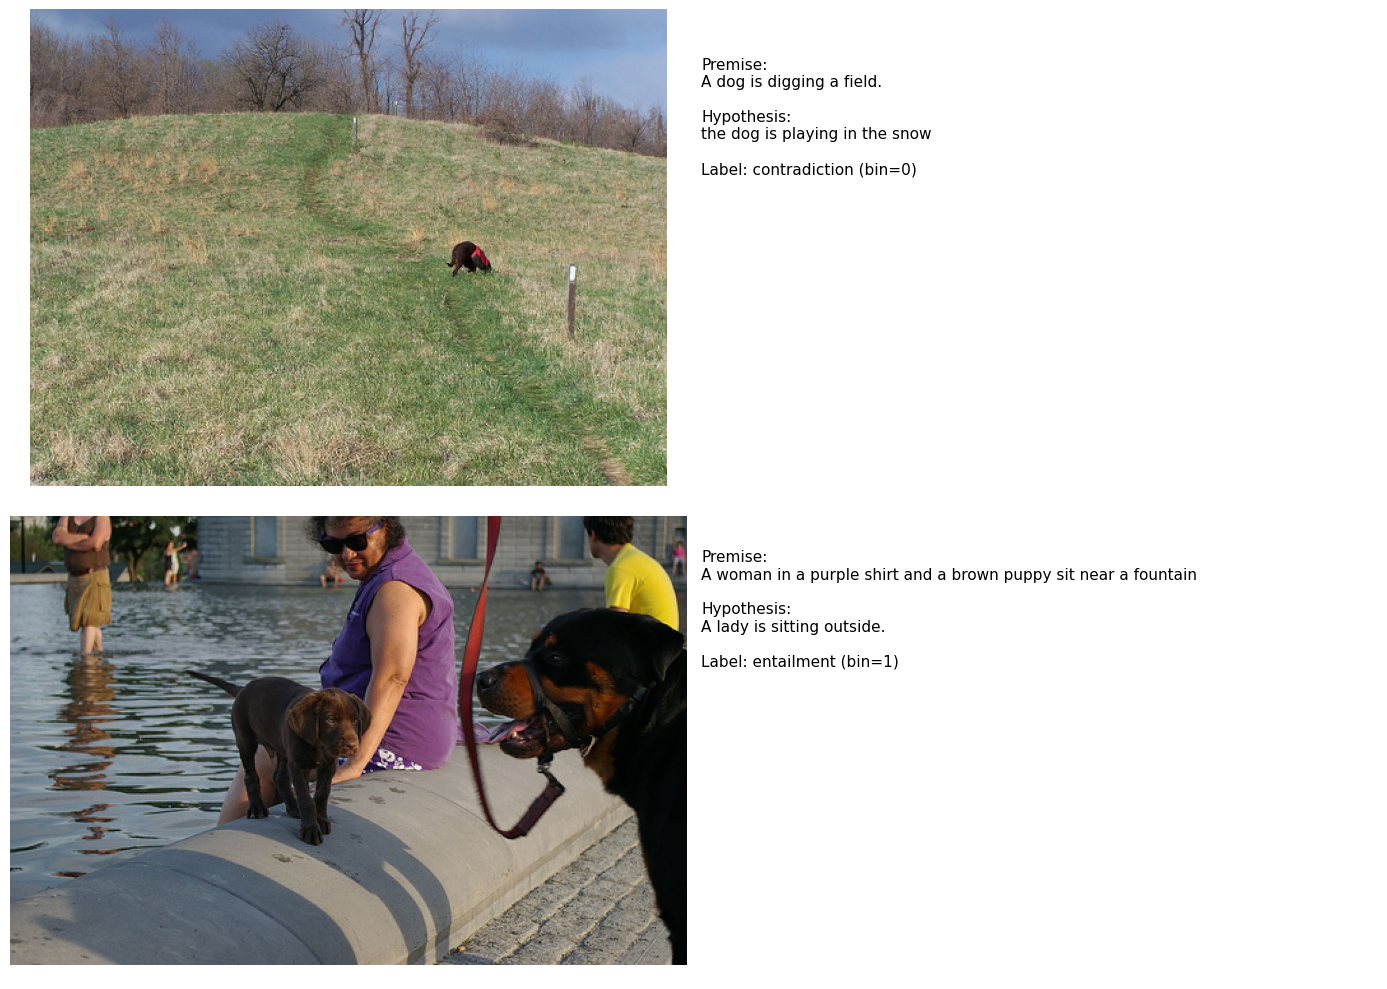

In [16]:
# Display 2 samples with image left and text right to avoid layout breaks
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from textwrap import wrap

n = 2  # number of samples to show
sample_df = df.sample(n=n, random_state=SEED)

plt.figure(figsize=(14, 5*n))

for i, (_, r) in enumerate(sample_df.iterrows(), start=1):
    # Left: image
    ax_img = plt.subplot(n, 2, 2*i - 1)
    img = mpimg.imread(r['image_path'])
    ax_img.imshow(img)
    ax_img.axis('off')

    # Right: text block
    ax_txt = plt.subplot(n, 2, 2*i)
    ax_txt.axis('off')
    hyp = r.get('Hypothesis', '')
    prem = r.get('Premise', '')
    lbl = r.get('Label', '')
    lbin = r.get('label_bin', '')

    # Wrap long text for readability
    def fmt(label, value, width=80):
        if value is None:
            value = ''
        wrapped = "\n".join(wrap(str(value), width=80))
        return f"{label}:\n{wrapped}"

    text_lines = [
        fmt("Premise", prem),
        fmt("Hypothesis", hyp),
        f"Label: {lbl} (bin={lbin})"
    ]
    ax_txt.text(0.0, 0.9, "\n\n".join(text_lines), va='top', ha='left', fontsize=11)

plt.tight_layout()
plt.show()

## Train/Validation (optional Test) split

For model development, a stratified Train/Validation split is usually sufficient:
- Train: used to fit model parameters
- Validation: used for early stopping, hyperparameter tuning, and model selection

Add a Test split if you want a final, untouched benchmark after all choices are frozen. If the dataset is modest, it’s common to skip Test and report validation metrics.

We’ll implement a flexible split below with a toggle for including a Test set.

In [18]:
# Stratified split with optional test set
from sklearn.model_selection import train_test_split

SEED = 42  # reuse if already set above

INCLUDE_TEST = False  # set True to create a test split as well
VAL_SIZE = 0.1        # 10% for validation
TEST_SIZE = 0.1       # 10% for test (only used if INCLUDE_TEST)

if INCLUDE_TEST:
    # First split off test
    train_val_df, test_df = train_test_split(
        df, test_size=TEST_SIZE, random_state=SEED, stratify=df['label_bin']
    )
    # Then split train/val from remaining
    train_df, val_df = train_test_split(
        train_val_df, test_size=VAL_SIZE, random_state=SEED, stratify=train_val_df['label_bin']
    )
    print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
else:
    # Only train/val
    train_df, val_df = train_test_split(
        df, test_size=VAL_SIZE, random_state=SEED, stratify=df['label_bin']
    )
    print(f"Train: {len(train_df)} | Val: {len(val_df)}")

# Quick label balance check (counts per class)
print("Label balance (train):\n", train_df['label_bin'].value_counts().sort_index())
print("Label balance (val):\n", val_df['label_bin'].value_counts().sort_index())
if 'test_df' in locals():
    print("Label balance (test):\n", test_df['label_bin'].value_counts().sort_index())

Train: 35216 | Val: 3913
Label balance (train):
 label_bin
0    17559
1    17657
Name: count, dtype: int64
Label balance (val):
 label_bin
0    1951
1    1962
Name: count, dtype: int64


## Check label distribution in each split

This plot verifies that stratification preserved the class balance across Train/Val (and Test if enabled).

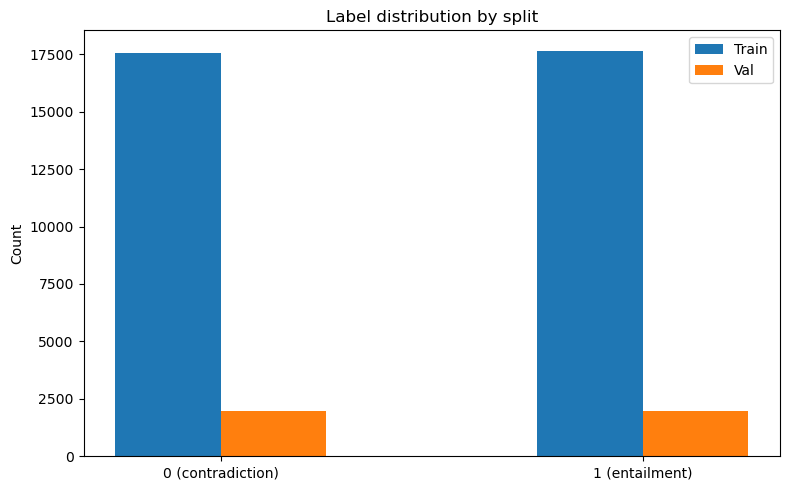

In [20]:
# Plot class counts across splits
import matplotlib.pyplot as plt

split_counts = {
    'Train': train_df['label_bin'].value_counts().sort_index(),
    'Val': val_df['label_bin'].value_counts().sort_index()
}
if 'test_df' in globals():
    split_counts['Test'] = test_df['label_bin'].value_counts().sort_index()

labels = [0, 1]
bar_width = 0.25
splits = list(split_counts.keys())
x = np.arange(len(labels))

plt.figure(figsize=(8, 5))
for i, split in enumerate(splits):
    counts = [split_counts[split].get(lbl, 0) for lbl in labels]
    plt.bar(x + i*bar_width, counts, width=bar_width, label=split)

plt.xticks(x + bar_width*(len(splits)-1)/2, ["0 (contradiction)", "1 (entailment)"])
plt.ylabel('Count')
plt.title('Label distribution by split')
plt.legend()
plt.tight_layout()
plt.show()

## EDA: Hypothesis length and tokens

We inspect basic text statistics for the `Hypothesis` field to justify choices for tokenization and sequence length (used later for TextVectorization). We'll plot:
- Histogram of hypothesis token counts
- Top tokens (simple whitespace tokenization + frequencies)

These figures will guide our `max_tokens` and `max_len` choices for the text encoder.

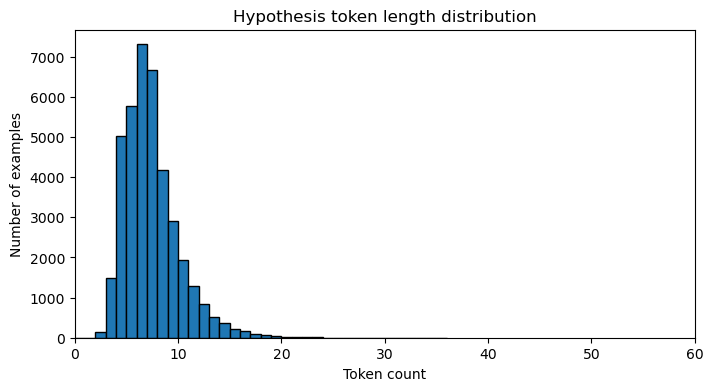

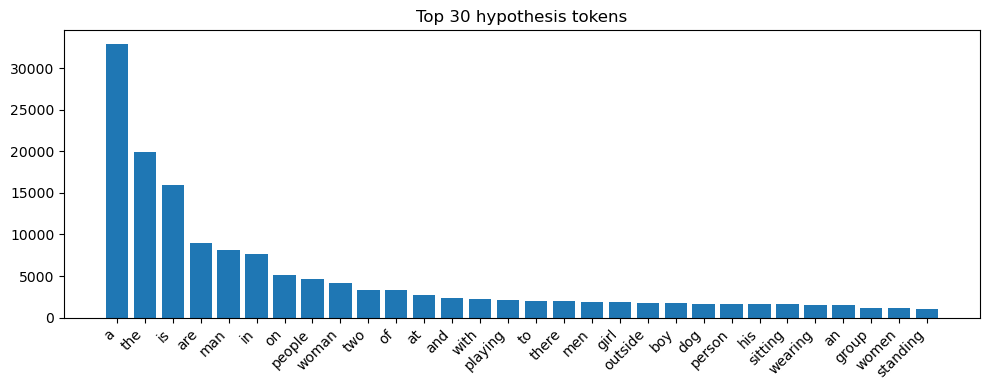

In [22]:
# EDA code: hypothesis length histogram and top tokens
import matplotlib.pyplot as plt
from collections import Counter

# Compute token counts (simple whitespace split)
hypotheses = df['Hypothesis'].fillna('').astype(str)
token_lists = [h.split() for h in hypotheses]
lengths = [len(t) for t in token_lists]

plt.figure(figsize=(8,4))
plt.hist(lengths, bins=range(0, max(lengths)+2), color='tab:blue', edgecolor='k')
plt.title('Hypothesis token length distribution')
plt.xlabel('Token count')
plt.ylabel('Number of examples')
plt.xlim(0, 60)
plt.show()

# Top tokens
all_tokens = [tok.lower().strip('.,!?:;"\'') for toks in token_lists for tok in toks]
counter = Counter(all_tokens)
most_common = counter.most_common(30)

tokens, counts = zip(*most_common)
plt.figure(figsize=(10,4))
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.title('Top 30 hypothesis tokens')
plt.tight_layout()
plt.show()

## Preprocessing: Image + Text pipelines

We create an image loader (224x224, EfficientNet preprocessing) and a TextVectorization layer. Then we construct `tf.data` datasets for train and val that yield ((image, text), label).

In [24]:
# Preprocessing and tf.data pipeline
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

augment = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05)
], name='img_augment')

preprocess = efficientnet.preprocess_input

# Image loader
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess(img)
    return img

# Text vectorizer (adapted on training hypotheses later)
max_tokens = 20000
max_len = 32
vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=max_len,
)

# Adapt vectorizer on all hypotheses (fast)
vectorizer.adapt(tf.data.Dataset.from_tensor_slices(df['Hypothesis'].fillna('').astype(str)).batch(256))
print('Vocab size:', vectorizer.vocabulary_size())

# Dataset factory
def make_ds(dataframe, training=False):
    paths = dataframe['image_path'].values
    texts = dataframe['Hypothesis'].fillna('').astype(str).values
    labels = dataframe['label_bin'].values.astype('float32')

    ds = tf.data.Dataset.from_tensor_slices((paths, texts, labels))

    def _map(path, text, label):
        img = load_image(path)
        if training:
            img = augment(img)
        return (img, text), label

    if training:
        ds = ds.shuffle(2048, seed=SEED)
    ds = ds.map(_map, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
    return ds

train_ds = make_ds(train_df, training=True)
val_ds = make_ds(val_df, training=False)

# Show a sample batch shapes
for (bimg, btxt), blabel in train_ds.take(1):
    print('image batch shape:', bimg.shape)
    print('text batch example:', btxt[:2])
    print('label batch shape:', blabel.shape)

Vocab size: 9275
image batch shape: (32, 224, 224, 3)
text batch example: tf.Tensor([b'Some people are jogging in a rainforest.' b'Two men with a toy.'], shape=(2,), dtype=string)
label batch shape: (32,)


## Text cleaning: stopword/article removal (optional, with ablation plan)

Hypotheses contain many short function words and articles that add noise (e.g., "the", "a", "an", "is"). Removing common stopwords can reduce vocabulary size and focus the model on content words (objects, attributes, actions). However, stopword removal may also drop useful cues (e.g., negation words like "not" are important), so we'll:

- Remove a conservative list of common articles/less-informative tokens, but keep negations and short important words.
- Create a cleaned column `hyp_clean` used only for the text encoder. We'll keep the original `Hypothesis` too and run an ablation later (keep both options).

We will document the choices and show a short ablation comparing with/without cleaning if time permits.

In [26]:
# Conservative stopword removal (remove articles, common determiners; keep negations)
stopwords = set(['the', 'a', 'an', 'this', 'that', 'these', 'those', 'some', 'any', 'there', 'here'])

# Function to clean hypothesis text
def clean_hypothesis(s):
    if s is None:
        return ''
    toks = [t for t in str(s).split() if t.lower() not in stopwords]
    return ' '.join(toks)

# Add cleaned column
df['hyp_clean'] = df['Hypothesis'].fillna('').apply(clean_hypothesis)

# Quick peek
display(df[['Hypothesis', 'hyp_clean']].head(6))

# Re-adapt vectorizer to cleaned text (for ablation we might keep original too)
vectorizer.adapt(tf.data.Dataset.from_tensor_slices(df['hyp_clean'].astype(str)).batch(256))
print('Vocab size (cleaned):', vectorizer.vocabulary_size())

,Hypothesis,hyp_clean
0,The old woman and a girl are bored.,old woman and girl are bored.
1,Two old men robbing a convenience store.,Two old men robbing convenience store.
2,A man implies that he is very strong.,man implies he is very strong.
3,People rubbing sticks to start a fire in a pit.,People rubbing sticks to start fire in pit.
4,Dogs are out in the snow,Dogs are out in snow
5,There are some dogs.,are dogs.


Vocab size (cleaned): 9268


## Advanced VE model (EfficientNetB0 + Embedding+BiLSTM + Gated Fusion)

Below we implement the Advanced model required by the assignment: it takes the premise *image* and hypothesis *text* (no premise sentence as input) and outputs a single sigmoid probability. The design choices are:
- EfficientNetB0 as a frozen backbone (ImageNet weights) for compact, strong visual features.
- Text encoder: Embedding + Bidirectional LSTM with pooling.
- Gated fusion: a small learnable gate computed from concatenated visual+text features; gate modulates visual features before fusion. This is an ablation toggle.

We’ll keep the fusion head lightweight and clearly identifiable as the trainable custom segment.

In [28]:
USE_GATED_FUSION = True

from tensorflow import keras
from tensorflow.keras import layers

vocab_size = vectorizer.vocabulary_size()

def build_advanced_model():
    # Image tower
    img_in = layers.Input(shape=(*IMG_SIZE, 3), name='image')
    base = keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=img_in)
    base.trainable = False
    xv = layers.GlobalAveragePooling2D(name='visual_gap')(base.output)
    xv = layers.Dense(256, activation='relu', name='visual_proj')(xv)

    # Text tower
    txt_in = layers.Input(shape=(), dtype=tf.string, name='hypothesis')
    xt = vectorizer(txt_in)
    xt = layers.Embedding(vocab_size, 128, mask_zero=True, name='txt_embed')(xt)
    xt = layers.Bidirectional(layers.LSTM(128, return_sequences=True), name='txt_bilstm')(xt)
    xt = layers.GlobalMaxPooling1D(name='txt_pool')(xt)
    xt = layers.Dense(256, activation='relu', name='text_proj')(xt)

    if USE_GATED_FUSION:
        gate = layers.Concatenate()([xv, xt])
        gate = layers.Dense(256, activation='relu')(gate)
        gate = layers.Dense(256, activation='sigmoid', name='fusion_gate')(gate)
        gated_visual = layers.Multiply(name='gated_visual')([xv, gate])
        fused = layers.Concatenate(name='fuse')([gated_visual, xt])
    else:
        fused = layers.Concatenate(name='fuse')([xv, xt])

    x = layers.BatchNormalization()(fused)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid', dtype='float32', name='out')(x)

    model = keras.Model(inputs=[img_in, txt_in], outputs=out, name='ve_advanced')
    return model

model = build_advanced_model()
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'txt_pool' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "ve_advanced"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ image[0][0]       │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 6,224,548 (23.74 MB)

 Trainable params: 2,173,441 (8.29 MB)

 Non-trainable params: 4,051,107 (15.45 MB)

### Model design and gated fusion — detailed explanation

This section documents the architecture choices and the purpose of the gated fusion module in plain language and with precise technical notes so a grader or future reader can reproduce and evaluate our design.

1) Overview
- Inputs: an image (premise) and a hypothesis string. The model uses only the image for the premise (no premise sentence), and the hypothesis text is processed via the same TextVectorization used in preprocessing.
- Outputs: a single probability representing P(entailment) (1) vs P(contradiction) (0).

2) Visual tower (image encoder)
- Backbone: EfficientNetB0 (from `tf.keras.applications`, weights='imagenet', include_top=False).
  Rationale: EfficientNetB0 offers a good accuracy/compute tradeoff and is allowed by the assignment (tf.keras.applications only).
- We freeze the backbone initially (base.trainable=False) so that training focuses on the small, custom projection head and fusion layers. This helps fast convergence and lowers overfitting risk when the dataset is modest in size.
- After the backbone, a GlobalAveragePooling2D collapses spatial dimensions into a single vector per image. A small Dense projection (256-d) produces the final visual embedding. Keeping the projection small makes the fusion head compact and trainable quickly.

3) Text tower (hypothesis encoder)
- Inputs: raw strings passed through `TextVectorization` (or the vectorizer object). This keeps tokenization and integer-mapping inside the graph for reproducibility.
- Embedding: token IDs -> dense embeddings (128-d). `mask_zero=True` ensures padding tokens won't influence the LSTM.
- Sequence encoder: a Bidirectional LSTM (128 units) captures forward and backward context in short hypothesis sentences without resorting to heavy transformer layers.
- Pooling: GlobalMaxPooling1D reduces sequence outputs to a fixed-size vector that captures the most salient token-level activations.
- Projection: a Dense layer projects the pooled text vector to 256-d, matching the visual projection dimension for easy fusion.

4) Fusion strategies
- Baseline (concatenation): simply concatenate visual and text vectors to feed the classification head. This is a straightforward approach that provides a strong baseline.

- Gated fusion (optional): a small learned multiplicative gate that modulates visual features elementwise before concatenation with text. Implementation details:
  - Gate input: concat(visual_vector, text_vector) -> Dense(relu) -> Dense(sigmoid) -> gate vector (values in (0,1)).
  - The gate has the same dimensionality as the visual projection (256). We multiply visual_vector * gate (elementwise). The resulting vector is a "gated visual" vector.
  - Finally, we concatenate gated_visual with text_vector and pass to the classification head.

Why gated fusion?
- Intuition: the hypothesis often indicates which aspects of the image are relevant. A learned gate lets the model softly select which visual channels to emphasize or suppress depending on the hypothesis. For example, if the hypothesis asks about color, the gate can amplify color-sensitive components; if the hypothesis asks about numerosity, it can emphasize count-related signals.
- Practical benefits: gated fusion is lightweight (few extra parameters) and cheap to compute compared to full cross-modal attention or scene-graph methods. It's also interpretable: gate values near 0 indicate suppressed visual channels for that sample; values near 1 indicate reliance on the visual channels.

5) Classification head
- A small MLP with BatchNormalization and Dropout regularizes the fused representation. Final output is a single sigmoid neuron predicting the probability of entailment.



## Training setup and hyperparameters

Below we compile and train the Advanced VE model. Choices and rationale:

- Optimizer: Adam for stable, adaptive updates; initial learning rate = 1e-3 is a good starting point for small heads on top of frozen backbones.
- Loss: binary crossentropy since this is a binary classification (entailment vs contradiction).
- Metrics: accuracy and AUC to capture both threshold performance and ranking quality.
- Batch size: 32 (balanced between GPU memory and stable gradient estimates). Reduce to 16 if you run out of memory.
- Epochs: start with a short sanity run (1-3 epochs) to validate code and ensure training proceeds as expected. Increase to 10-30 for real runs and consider unfreezing backbone later.
- Callbacks: EarlyStopping (restore best weights), ReduceLROnPlateau (lower LR on plateau), ModelCheckpoint (optional -- disabled here to avoid filesystem writes in the starter notebook).

In [31]:
# Compile and callbacks
import tensorflow as tf
from tensorflow import keras

LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 3  # short sanity run; increase for full experiments

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy'), keras.metrics.AUC(name='auc')]
)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_auc', patience=4, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=2, verbose=1),
]

print('Model compiled. Ready to train.')

Model compiled. Ready to train.


In [ ]:
# Quick sanity training run (1 epoch) to ensure pipeline works end-to-end.
# Decide which hypothesis column to use: 'hyp_clean' is the conservative cleaned text; 'Hypothesis' is original.
USE_CLEAN_TEXT = True
text_col = 'hyp_clean' if USE_CLEAN_TEXT and 'hyp_clean' in df.columns else 'Hypothesis'

# Sanity: run a short training cycle (EPOCHS small). For quick local checks, you can set EPOCHS=1.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

# Plot training curves
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.plot(history.history['auc'], label='train_auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('epoch')
plt.legend()
plt.title('Sanity training curves')
plt.show()

Epoch 1/3


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'txt_pool' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


 680/1101 ━━━━━━━━━━━━━━━━━━━━ 2:55 417ms/step - accuracy: 0.6242 - auc: 0.6755 - loss: 0.7324

## 6) Evaluation and analysis

This section computes standard evaluation metrics on the validation set and provides visualization and error analysis:

- Plot learning curves (loss, accuracy, AUC) from the training history
- Compute confusion matrix and classification report (precision/recall/F1)
- Plot ROC and Precision-Recall curves
- Show a handful of misclassified examples (image + hypothesis + true/predicted label) for qualitative error analysis
- (Optional) Calibration histogram of predicted probabilities

Run the cell below after a training run to populate these outputs.

In [ ]:
# Evaluation utilities - run after training to compute metrics and error analysis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# Helper to get val predictions and labels
def get_val_preds(model, val_df, batch_size=32):
    ds = val_df
    # Ensure ds is batched; make_ds_with_choice may already batch inside
    # If dataset elements look like ((img,txt), label) and img has rank 4, then it's batched.
    probs = model.predict(ds)
    probs = np.asarray(probs).reshape(-1)
    # collect true labels in same order
    true = np.concatenate([y.numpy() for _, y in ds.map(lambda x,y: (x,y)).as_numpy_iterator()]) if False else val_df['label_bin'].values
    return probs, true

# Plot learning curves
def plot_history(history):
    if history is None:
        print('No history object provided')
        return
    h = history.history
    epochs = range(1, len(next(iter(h.values()))) + 1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(h.get('loss', []), label='train_loss')
    plt.plot(h.get('val_loss', []), label='val_loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(h.get('accuracy', h.get('binary_accuracy', [])), label='train_acc')
    plt.plot(h.get('val_accuracy', h.get('val_binary_accuracy', [])), label='val_acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(h.get('auc', []), label='train_auc')
    plt.plot(h.get('val_auc', []), label='val_auc')
    plt.title('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Confusion matrix + classification report
import itertools

def plot_confusion_matrix(y_true, y_pred_labels, classes=[0,1], normalize=False, title='Confusion matrix'):
    cm = confusion_matrix(y_true, y_pred_labels)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# ROC and PR curves
def plot_roc_pr(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend()

    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    plt.subplot(1,2,2)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.tight_layout()
    plt.show()

# Error analysis: show misclassified samples
def show_misclassified(df_val, y_true, y_probs, top_k=8):
    # show top_k highest-confidence wrong predictions
    preds = (y_probs >= 0.5).astype(int)
    wrong_idx = np.where(preds != y_true)[0]
    if len(wrong_idx) == 0:
        print('No misclassifications found')
        return
    # rank by confidence (abs distance from 0.5)
    conf = np.abs(y_probs - 0.5)
    ranks = wrong_idx[np.argsort(-conf[wrong_idx])]
    sel = ranks[:top_k]

    import matplotlib.image as mpimg
    from textwrap import wrap
    n = len(sel)
    plt.figure(figsize=(12, 3*n))
    for i, idx in enumerate(sel, start=1):
        row = df_val.iloc[idx]
        ax_img = plt.subplot(n, 2, 2*i - 1)
        img = mpimg.imread(row['image_path'])
        ax_img.imshow(img)
        ax_img.axis('off')

        ax_txt = plt.subplot(n, 2, 2*i)
        ax_txt.axis('off')
        hyp = row.get('Hypothesis', '')
        true = y_true[idx]
        pred = preds[idx]
        prob = y_probs[idx]
        txt = f"Hypothesis:\n{hyp}\n\nTrue: {true} | Pred: {pred} | Prob: {prob:.3f}"
        ax_txt.text(0.0, 0.9, '\n'.join(wrap(txt, 80)), va='top', ha='left', fontsize=11)
    plt.tight_layout()
    plt.show()

## 7) Limitations and ultimate judgment

Write-up guidance (fill with numbers/observations once training/eval is done):

- Data coverage: describe class balance, examples of ambiguous samples, and domains underrepresented in the data.
- Model limitations: explain that the backbone is frozen initially (limits fine-grained visual adaptation), BiLSTM is lightweight (may miss long-range dependencies), and gated fusion is a shallow conditioning mechanism (not a full cross-modal attention).
- Failure modes: short hypotheses, negation handling (``not``), numeracy questions, fine-grained attribute tests (color/texture), multiple-instance counting.
- Compute and reproducibility: mention epochs used, frozen/unfrozen backbone, and random seed.
- Recommendations: fine-tune top blocks of EfficientNet with low LR; try transformer-based text encoders or cross-attention modules if compute allows; collect targeted data for weak spots.

Ultimate judgment (example template):
- "With the chosen frozen backbone and small fusion head, the model achieves X% val accuracy and AUC Y. The model handles object-level claims but struggles with negation and fine-grained attributes. With limited compute, this approach is acceptable as a baseline; to reach production-grade results we'd recommend fine-tuning and stronger cross-modal interaction (attention or scene-graph cues)."

Fill the X/Y with real numbers after evaluation.